In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import re
from itertools import combinations

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data
    

In [2]:
data_root = './data/cities_json'
bios_path = './data/all_bios_embeddings.csv'

In [3]:
files = os.listdir(data_root+'/London')

In [4]:
files[0]

'Wealth-X Hamad bin Khalifa bin Hamad bin Abdullah bin Jassim Al Thani Dossier.pkl'

Cite this in the network write up

GPT-NER: Named Entity Recognition via Large Language Models
https://arxiv.org/abs/2304.10428




In [7]:
example = load_pickle_file(data_root+'/London/' + files[1])

example.keys()

dict_keys(['biography', 'career_history', 'clubs_and_boards', 'philanthropy', 'known_associates', 'service_providers', 'family_details', 'summary'])

In [8]:
example['summary'].at[0,'Residences']

'London, Greater London, United Kingdom'

In [66]:
#The below lookup ensures that the reference country is always included in the list of countries
city_country_converter= pd.DataFrame({
    'reference_country':['united states', 'united states', 'united kingdom', 'nigeria', 'mexico', 'germany', 'south africa', 'hong kong', 'brazil', 'australia'],
'reference_city':['new york', 'san francisco bay area','london', 'lagos', 'mexico city', 'franfurt',  'johannesburg', 'hong kong', 'sao paolo', 'sydney']}
)

city_country_converter['color'] = 'red'


In [61]:
def extract_residences(file_path):

    """
    Extracts the 'Residences' information from a pickle file.

    This function attempts to load a pickle file located at the specified file path.
    It extracts the 'Residences' data from the 'summary' section of the loaded file.
    Additionally, it captures any errors encountered during the extraction process.

    Parameters:
    - file_path (str): The path to the pickle file from which to extract the 'Residences' information.

    Returns:
    - pd.DataFrame: A DataFrame containing the following columns:
        - 'file': The name of the file from which the 'Residences' information was extracted.
        - 'error': A boolean indicating whether an error was encountered during extraction.
        - 'Residences': The extracted 'Residences' information, if available; otherwise, None.

    Raises:
    - KeyError: If the 'summary' or 'Residences' key is not found in the pickle file.
    - TypeError: If the file loaded is not a pickle file or is improperly formatted.
    """

    # Try to load the pickle file
    try:
        temp_dict = load_pickle_file(file_path)
        residences = temp_dict['summary'].at[0,'Residences']
        error = False
    except (KeyError, TypeError):
        residences = None
        error = True

    # Extract file name from the file path
    file_name = file_path.split('/')[-1]
    
    # Return the desired DataFrame
    df = pd.DataFrame({
        'file': [file_name],
        'error': [error],
        'Residences': [residences]
    })
    
    return df

def process_files(files_list):
    """
    Processes a list of file paths to extract 'Residences' information from each.

    This function iterates over a given list of file paths, calling the 'extract_residences'
    function on each file to extract the 'Residences' information. The results are concatenated
    into a single DataFrame.

    Parameters:
    - files_list (list of str): A list of file paths to be processed.

    Returns:
    - pd.DataFrame: A DataFrame containing the combined results from all files in the list.
      It includes the following columns:
        - 'file': The name of each file processed.
        - 'error': A boolean indicating whether an error was encountered during extraction
                   for each file.
        - 'Residences': The extracted 'Residences' information from each file, if available;
                        otherwise, None.

    Notes:
    - The function assumes that the 'extract_residences' function is defined and accessible.
    - The resulting DataFrame will have a boolean 'error' column, and its dtype is set accordingly.
    """

    # Create an empty DataFrame
    combined_df = pd.DataFrame(columns=['file', 'error', 'Residences'])
    combined_df['error'] = combined_df['error'].astype(bool)
    # Loop through the list of files and concatenate DataFrames
    for file_path in files_list:
        df_result = extract_residences(file_path)
        combined_df = pd.concat([combined_df, df_result], ignore_index=True)
    
    return combined_df


def extract_cities(target_df, reference_df, ref_type='city_ascii', ref_col = 'reference_city'):

    """
    Extracts a list of city names from a target DataFrame based on a reference DataFrame.

    This function processes the 'Residences' column in the target DataFrame, extracting city names
    that match any city name in the reference DataFrame. The reference DataFrame must have a column
    with city names specified by the 'ref_type' parameter. The resulting lists of city names are 
    added as a new column to the target DataFrame.

    Parameters:
    - target_df (pd.DataFrame): The DataFrame containing the 'Residences' column from which city names are to be extracted.
    - reference_df (pd.DataFrame): The reference DataFrame containing city names.
    - ref_type (str, optional): The column name in the reference DataFrame that contains city names. Defaults to 'city_ascii'.
    - ref_col (str, optional): The column name in the reference DataFrame that contains the reference city/country names. Defaults to 'reference_city'.

    Returns:
    - pd.DataFrame: The target DataFrame with an added column named '<ref_type>_list', containing lists of extracted city names.

    Raises:
    - KeyError: If the 'ref_type' column is not found in the reference DataFrame or if 'Residences' is not found in the target DataFrame.

    Notes:
    - The function creates a regular expression pattern to identify city names in the 'Residences' column.
    - City names that contain special characters like "." or "+" are properly escaped for regex matching.
    - Only unique city names are retained in the resulting lists for each row in the target DataFrame.
    - The function operates on copies of the provided DataFrames and does not modify the originals.
    """

    target_df = target_df.copy()
    reference_df = reference_df.copy()
    
    # Convert the reference cities to a list and filter out any empty or whitespace-only strings
    city_list = [city for city in reference_df[ref_type].tolist() if city and city.strip()]
    
    # Ensure that city names that contain special characters like "." or "+" are properly escaped for regex
    city_list = [re.escape(city) for city in city_list]
    
    # Create a regex pattern using the city_list
    pattern = r'\b(' + '|'.join(city_list) + r')\b'
    
    # Extract cities from the target dataframe using the pattern
    target_df[ref_type+'_list'] = target_df['Residences'].str.findall(pattern)
    
    # Convert 'reference_city' to a list containing a single element (the city)
    target_df['reference_city_list'] = target_df[ref_col].apply(lambda x: [x])
    
    # Add the city from 'reference_city' column to the list
    target_df[ref_type+'_list'] += target_df['reference_city_list']
    
    # Ensure unique cities by converting list to set and then back to list
    target_df[ref_type+'_list'] = target_df[ref_type+'_list'].apply(lambda x: list(set(x)))
    
    # Drop the temporary 'reference_city_list' column
    target_df.drop('reference_city_list', axis=1, inplace=True)
    
    return target_df


def binary_representation(df, column_name):

    """
    Transforms a column in the DataFrame containing lists of items into a binary representation.

    This function takes a DataFrame and a column name as input. The column should contain lists
    of items (e.g., countries, cities). It then transforms this column into a binary
    representation where each unique item in the lists gets its own column in the DataFrame. 
    If an item is present in the list for a row, the corresponding column will have a value of 1;
    otherwise, 0.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be transformed.
    - column_name (str): The name of the column containing lists of items.

    Returns:
    - pd.DataFrame: A new DataFrame with the original column replaced by a set of binary columns,
                    one for each unique item found in the lists of the original column.

    Notes:
    - The function creates a copy of the input DataFrame to avoid modifying the original DataFrame.
    - The original column containing lists is dropped after transformation.
    """

    df = df.copy()

    # Get unique countries/cities from the dataframe
    unique_items = set(item for sublist in df[column_name] for item in sublist)
    
    # Create binary columns for each unique country/city and store them in a list
    new_cols = []
    for item in unique_items:
        new_cols.append(df[column_name].apply(lambda x: 1 if item in x else 0).rename(item))
    
    # Concatenate the new columns to the original DataFrame
    df = pd.concat([df] + new_cols, axis=1)
    
    # Drop the original column
    df = df.drop(column_name, axis=1)
    
    return df


def create_city_network(df, column_name):

    """
    Creates a network (graph) representation of connections between cities.

    This function takes a DataFrame and a column name as input. The specified column should
    contain lists of cities. A graph is then constructed where each city represents a node,
    and edges are created between cities that appear together in the same list. The weight of
    an edge represents the number of times two cities appear together.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the city lists.
    - column_name (str): The name of the column containing lists of cities.

    Returns:
    - nx.Graph: A networkx Graph object representing the city network. Nodes correspond to cities,
                and edges connect cities that appear together in the lists. Edge weights represent
                the frequency of co-occurrence.

    Notes:
    - The function assumes that the 'combinations' function from the 'itertools' module and the
      'nx' (networkx) module are imported.
    - If two cities appear together more than once across the lists, the corresponding edge's
      weight is incremented accordingly.
    """

    G = nx.Graph()
    
    for city_list in df[column_name]:
        # For each list of cities, generate pairs of cities
        for city1, city2 in combinations(city_list, 2):
            if G.has_edge(city1, city2):
                # If the edge already exists, we increase the edge weight (optional)
                G[city1][city2]['weight'] += 1
            else:
                # If the edge doesn't exist, we add it with weight 1 (or without weight)
                G.add_edge(city1, city2, weight=1)
    
    return G

# Load list of cities and countries

This loads a csv from 'simplemaps' which contains a large number of global cites. the 10 largest cities are taken from each country

In [30]:
cities_df = pd.read_csv('./data/simplemaps_worldcities_basicv1.76/worldcities.csv')

cities_df = cities_df.groupby('country', group_keys=False).apply(lambda g: g.nlargest(50, 'population')).reset_index(drop=True)
cities_df['city_ascii'] = cities_df['city_ascii'].str.lower()
cities_df['country'] = cities_df['country'].str.lower()
cities_df = cities_df.loc[cities_df['population']>100000,:]

cities_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Kabul,kabul,34.5253,69.1783,afghanistan,AF,AFG,Kābul,primary,4273156.0,1004993580
1,Kandahār,kandahar,31.6200,65.7158,afghanistan,AF,AFG,Kandahār,admin,614254.0,1004003059
2,Herāt,herat,34.3419,62.2031,afghanistan,AF,AFG,Herāt,admin,556205.0,1004237782
3,Farāh,farah,32.3436,62.1194,afghanistan,AF,AFG,Farāh,admin,500000.0,1004523791
4,Mazār-e Sharīf,mazar-e sharif,36.7000,67.1167,afghanistan,AF,AFG,Balkh,admin,469247.0,1004436363
...,...,...,...,...,...,...,...,...,...,...,...
7088,Harare,harare,-17.8292,31.0522,zimbabwe,ZW,ZWE,Harare,primary,2150000.0,1716196799
7089,Bulawayo,bulawayo,-20.1700,28.5800,zimbabwe,ZW,ZWE,Bulawayo,admin,653337.0,1716032632
7090,Chitungwiza,chitungwiza,-17.9939,31.0481,zimbabwe,ZW,ZWE,Harare,NaN,371244.0,1716688236
7091,Mutare,mutare,-18.9667,32.6333,zimbabwe,ZW,ZWE,Manicaland,admin,224802.0,1716060405


In [31]:
cities_df.loc[cities_df['city_ascii'].str.contains('san$', case=False, na=False),:]

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
4660,Wŏnsan,wonsan,39.1475,127.4461,north korea,KP,PRK,Kangwŏn,admin,363127.0,1408692125
4672,Hyesan,hyesan,41.4000,128.1833,north korea,KP,PRK,Ryanggang,admin,192680.0,1408642146
5756,Busan,busan,35.1800,129.0750,south korea,KR,KOR,Busan,admin,3453198.0,1410601465
5762,Ulsan,ulsan,35.5500,129.3167,south korea,KR,KOR,Ulsan,admin,1166033.0,1410134602
5771,Ansan,ansan,37.3167,126.8333,south korea,KR,KOR,Gyeonggi,NaN,652800.0,1410585171
5779,Masan,masan,35.1833,128.5500,south korea,KR,KOR,Gyeongnam,NaN,429612.0,1410394650
5787,Asan,asan,36.7833,126.9833,south korea,KR,KOR,Chungnam,NaN,332790.0,1410521090
5789,Asan,asan,36.3500,126.9167,south korea,KR,KOR,Chungnam,NaN,319929.0,1410904940
5792,Iksan,iksan,35.9439,126.9544,south korea,KR,KOR,Jeonbuk,NaN,302310.0,1410134391
5793,Yangsan,yangsan,35.3333,129.0333,south korea,KR,KOR,Gyeongnam,minor,297532.0,1410795549


# Load and process residence information

In [70]:
all_data_df = []

for city in os.listdir(data_root):
    print(city)
    files = os.listdir(data_root+'/'+city)
    city_temp = process_files([data_root+'/'+city+'/' +x for x in files])

    city_temp['reference_city'] = city.lower()
    all_data_df.append(city_temp)

all_data_df = pd.concat(all_data_df, ignore_index=True)

all_data_df['Residences'] = all_data_df['Residences'].str.lower()

all_data_df = all_data_df.merge(city_country_converter, how='left', on='reference_city')

missing_data = all_data_df.loc[all_data_df['error']==True,:].copy()

all_data_df = extract_cities(all_data_df.loc[all_data_df['error']!=True,:], cities_df)
all_data_df = extract_cities(all_data_df, cities_df, 'country', 'reference_country')

all_data_df['reference_city'] = all_data_df['reference_city'].replace('san francisco bay area', 'san francisco')


Lagos
Johannesburg
Hong Kong
Rio de Janeiro
San Francisco Bay Area
Mexico City
Frankfurt
London
Sydney
New York


In [72]:
all_data_df

,file,error,Residences,reference_city,reference_country,color,city_ascii_list,country_list
0,L265 Wealth-X Kola Edward EDGAL Dossier.pkl,False,"london, greater london, united kingdom victori...",lagos,nigeria,red,"[london, lagos, victoria]","[nigeria, united kingdom]"
1,L195 Wealth-X Victor Gbolade OSIBODU Dossier.pkl,False,nigeria,lagos,nigeria,red,[lagos],[nigeria]
2,L256 Wealth-X Harrison Eyitayo ILORI Dossier.pkl,False,"london, greater london, united kingdom victori...",lagos,nigeria,red,"[london, lagos, victoria]","[nigeria, united kingdom]"
3,L145 Wealth-X Deji ALLI Dossier.pkl,False,"ikoyi, lagos, nigeria",lagos,nigeria,red,[lagos],[nigeria]
4,L135 Wealth-X Ishwardas MAHTANI Dossier.pkl,False,"mumbai, maharashtra, india",lagos,nigeria,red,"[mumbai, lagos]","[india, nigeria]"
...,...,...,...,...,...,...,...,...
2863,N341 Wealth-X Robert Jeffrey SPEYER Dossier.pkl,False,"new york, new york, united states",new york,united states,red,[new york],[united states]
2864,N276 Wealth-X Madonna Louise Veronica CICCONE ...,False,"new york, new york, united states hidden hills...",new york,united states,red,"[lisbon, new york]","[portugal, united states]"
2865,N069 Wealth-X Stephen Alan WYNN Dossier.pkl,False,"beverly hills, california, united states new y...",new york,united states,red,"[new york, las vegas]",[united states]
2866,N133 Wealth-X Fawaz Abdulaziz Fahad ALHOKAIR D...,False,"riyadh, ar riyadh, saudi arabia new york, new ...",new york,united states,red,"[riyadh, new york, los angeles]","[saudi arabia, united states]"


In [68]:
city_country_lookup = pd.DataFrame({'reference_city':all_data_df['reference_city'].unique(),
'reference_country':['nigeria', 'south africa', 'hong kong', 'brazil', 'united states', 
 'mexico', 'germany', 'united kingdom', 'australia', 'united states']})

city_country_lookup['reference_city'] = city_country_lookup['reference_city'].replace('san francisco bay area', 'san francisco')

city_country_lookup['color'] = 'red'

In [69]:
city_country_lookup

,reference_city,reference_country,color
0,lagos,nigeria,red
1,johannesburg,south africa,red
2,hong kong,hong kong,red
3,rio de janeiro,brazil,red
4,san francisco,united states,red
5,mexico city,mexico,red
6,frankfurt,germany,red
7,london,united kingdom,red
8,sydney,australia,red
9,new york,united states,red


In [71]:
country_count_ex_ref = []

for ref_city in all_data_df['reference_city'].unique():

    binary_country_df = binary_representation(all_data_df.loc[all_data_df['reference_city']==ref_city,:], 'country_list')
    #The reference country needs to be dropped
    #ref_country = city_country_lookup.loc[city_country_lookup['reference_city']== ref_city,:].iat[0,1]
    binary_country_df = binary_country_df.drop(['file', 'error', 'Residences', 'reference_city', 'city_ascii_list', ref_country], axis = 1).sum(axis = 0)
    binary_country_df = binary_country_df.sort_values().reset_index().rename(columns={'index':'country', 0:'counts'})

    country_count_ex_ref.append(binary_country_df)

country_count_ex_ref = pd.concat(country_count_ex_ref, ignore_index=True).groupby('country').sum().reset_index()

sns.barplot(data = country_count_ex_ref.loc[:,:].nlargest(10, 'counts'), x = 'country', y = 'counts')
plt.title('Country of residenice excluding reference country')
plt.xticks(rotation=45, ha="right") 
plt.show()


TypeError: '<' not supported between instances of 'numpy.ndarray' and 'str'

In [45]:
all_data_df.loc[all_data_df['reference_city'].str.contains('san'),:]

,file,error,Residences,reference_city,city_ascii_list,country_list
847,B181 Wealth-X Jayshree Vedantham ULLAL Dossier...,False,"saratoga, california, united states",san francisco,[],[united states]
848,B091 Wealth-X John A. PRITZKER Dossier.pkl,False,"san francisco, california, united states",san francisco,[san francisco],[united states]
849,B115 Wealth-X Kathryn Ann TAYLOR Dossier.pkl,False,"south carolina, united states san francisco, c...",san francisco,"[san francisco, carolina]",[united states]
850,B022 Wealth-X Yuan Hsiu CHAO Dossier.pkl,False,"houston, texas, united states el cerrito, cali...",san francisco,[houston],[united states]
851,B219 Wealth-X Paul L. HULME Dossier.pkl,False,"redwood city, california, united states sarato...",san francisco,[san jose],[united states]
...,...,...,...,...,...,...
1241,B156 Wealth-X Adam NEUMANN Dossier.pkl,False,"water mill, new york, united states new york, ...",san francisco,"[san francisco, new york]",[united states]
1242,B322 Wealth-X Peter J. LEVINE Dossier.pkl,False,"portola valley, california, united states sant...",san francisco,[],[united states]
1243,B303 Wealth-X David T. TRAITEL Dossier.pkl,False,"san francisco, california, united states ranch...",san francisco,[san francisco],[united states]
1244,B175 Wealth-X David Carl DRUMMOND Dossier.pkl,False,"monte sereno, california, united states",san francisco,[],[united states]


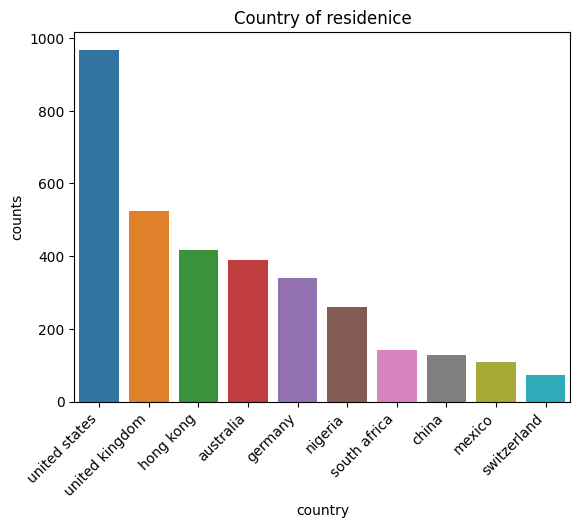

In [37]:
binary_country_df = binary_representation(all_data_df, 'country_list')

binary_country_df = binary_country_df.drop(['file', 'error', 'Residences', 'reference_city', 'city_ascii_list'], axis = 1).sum(axis = 0).sort_values().reset_index().rename(columns={'index':'country', 0:'counts'})
binary_country_df 
sns.barplot(data = binary_country_df.loc[:,:].nlargest(10, 'counts'), x = 'country', y = 'counts')
plt.title('Country of residenice')
plt.xticks(rotation=45, ha="right") 
plt.show()

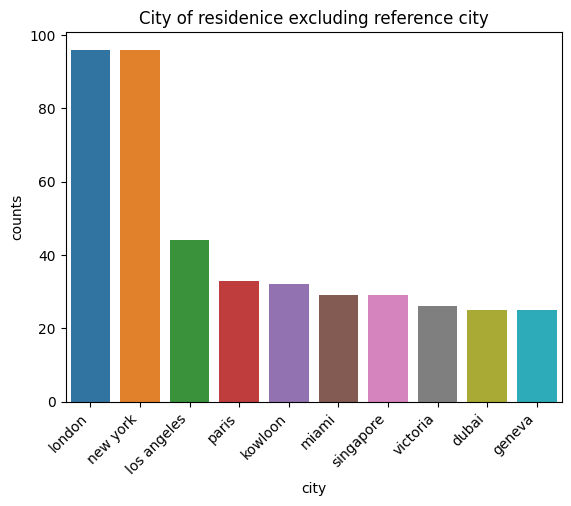

In [48]:
city_count_ex_ref = []

for ref_city in all_data_df['reference_city'].unique():

    binary_city_df = binary_representation(all_data_df.loc[all_data_df['reference_city']==ref_city,:], 'city_ascii_list')
    #The reference city needs to be dropped
    columns_to_drop = ['file', 'error', 'Residences', 'reference_city', 'country_list']

    if ref_city in binary_city_df.columns:
        columns_to_drop.append(ref_city)

    binary_city_df = binary_city_df.drop(columns_to_drop, axis = 1).sum(axis = 0)
    binary_city_df = binary_city_df.sort_values().reset_index().rename(columns={'index':'city', 0:'counts'})

    city_count_ex_ref.append(binary_city_df)

city_count_ex_ref = pd.concat(city_count_ex_ref, ignore_index=True).groupby('city').sum().reset_index()

sns.barplot(data = city_count_ex_ref.loc[~city_count_ex_ref['city'].isin(['california', 'australia', 'florida', 'mexico', 'colorado'])
                                         ,:].nlargest(10, 'counts'), x = 'city', y = 'counts')
plt.title('City of residenice excluding reference city')
plt.xticks(rotation=45, ha="right") 
plt.show()



In [39]:
city_count_ex_ref.sort_values('counts', ascending=False).iloc[0:30,:]

,city,counts
85,london,96
112,new york,96
86,los angeles,44
118,paris,33
76,kowloon,32
163,singapore,29
102,miami,29
181,victoria,26
44,dubai,25
49,geneva,25


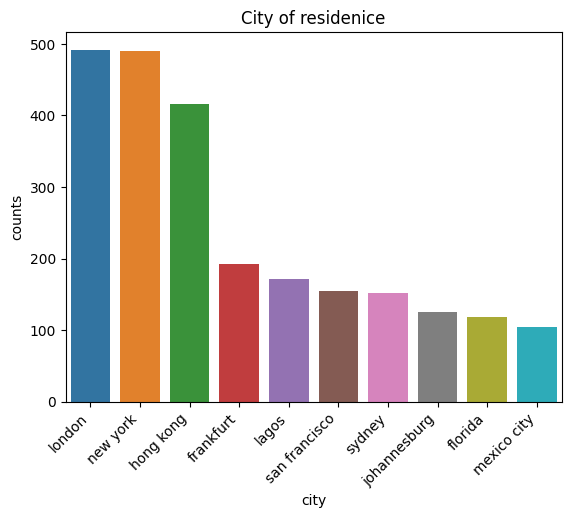

In [16]:
binary_city_df = binary_representation(all_data_df,'city_ascii_list')

binary_city_df = binary_city_df.drop(['file', 'error', 'Residences','reference_city',  'country_list'], axis = 1).sum(axis = 0).sort_values().reset_index().rename(columns={'index':'city', 0:'counts'})

sns.barplot(data = binary_city_df.loc[:,:].nlargest(10, 'counts'), x = 'city', y = 'counts')
plt.title('City of residenice')
plt.xticks(rotation=45, ha="right") 
plt.show()

In [37]:
G = create_city_network(all_data_df, 'country_list')


In [38]:
# Get edge weights
edge_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

# Convert to a DataFrame
df = pd.DataFrame(edge_weights, columns=['Node1', 'Node2', 'Weight'])

df.sort_values('Weight', ascending=False).nlargest(20,'Weight').to_csv('./data/top_edge_weights.csv')

print(df.sort_values('Weight', ascending=False).nlargest(20,'Weight'))

              Node1                 Node2  Weight
24   united kingdom         united states     128
218           china             hong kong     106
30   united kingdom           switzerland      58
29   united kingdom                france      56
0           nigeria        united kingdom      46
112   united states             hong kong      43
104   united states                france      42
28   united kingdom                monaco      31
42   united kingdom                russia      30
1           nigeria         united states      29
39   united kingdom             hong kong      29
105   united states           switzerland      29
32   united kingdom          south africa      28
23   united kingdom                 india      27
98    united states                jersey      27
101   united states                 china      25
246          france           switzerland      23
31   united kingdom  united arab emirates      22
318       hong kong             singapore      19


In [39]:
country = 'mexico'
df.loc[(df['Node1']==country)|(df['Node2']==country),:].sort_values('Weight', ascending=False)

,Node1,Node2,Weight
130,united states,mexico,12
204,spain,mexico,3
228,italy,mexico,1
378,germany,mexico,1
382,mexico,israel,1


In [35]:
# Compute weighted betweenness centrality
betweenness = nx.betweenness_centrality(G, weight='weight')

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(betweenness.items()), columns=['Node', 'Weighted Betweenness Centrality']).sort_values('Weighted Betweenness Centrality', ascending=False)

df.to_csv('./data/betweeness_centrality.csv')
df.nlargest(20, 'Weighted Betweenness Centrality')

,Node,Weighted Betweenness Centrality
1,united kingdom,0.299400
2,united states,0.210854
12,france,0.123031
20,hong kong,0.105064
0,nigeria,0.103099
13,switzerland,0.084670
7,spain,0.046386
9,china,0.046274
36,australia,0.039419
29,canada,0.037399


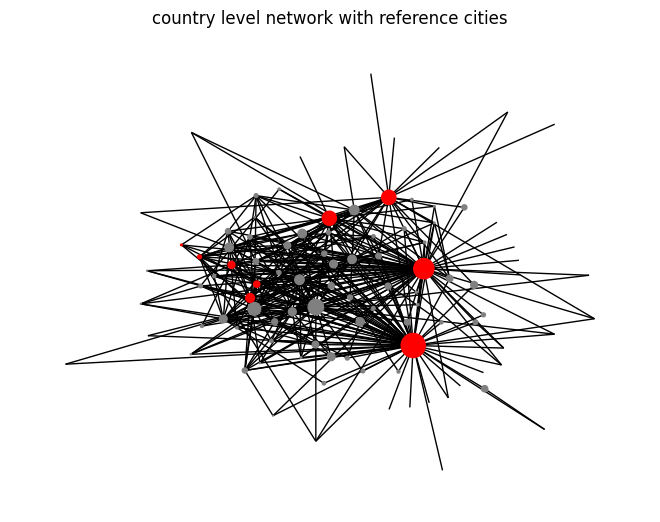

In [20]:
# Create a list of colors for each node using the color_map dictionary

#edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 1]
#G.remove_edges_from(edges_to_remove)


node_color_dict = dict(city_country_lookup[['reference_country', 'color']].values)
node_colors = [node_color_dict.get(node, 'gray') for node in G.nodes()]

centrality_value = nx.betweenness_centrality(G, weight='weight')

# Scale centrality values to set node sizes (e.g., multiply by 1000 for better visualization)
node_sizes = [centrality_value[node] * 1000 for node in G.nodes()]


# Draw the graph
nx.draw(G, with_labels=False, node_color=node_colors, node_size=node_sizes, pos = nx.kamada_kawai_layout(G,scale=5))
plt.title('country level network with reference cities')
plt.show()

In [21]:
# Get connected components
connected_components = list(nx.connected_components(G))

# Calculate the number of nodes in each component
component_node_counts = [len(component) for component in connected_components]

print(component_node_counts)

[100]


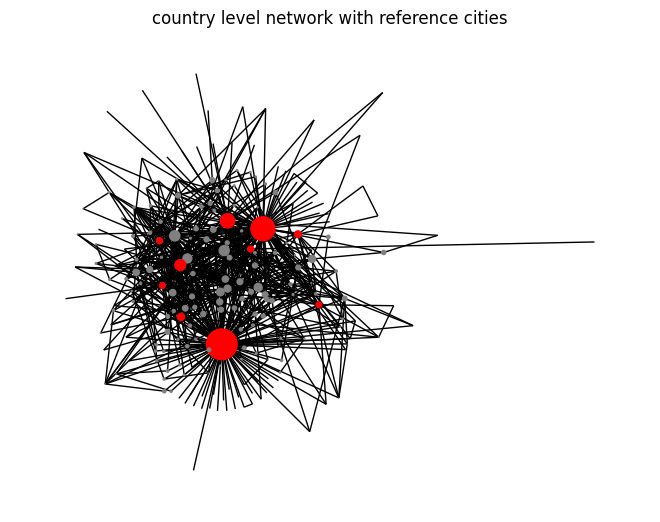

In [22]:
G = create_city_network(all_data_df, 'city_ascii_list')
color_map = dict(zip(city_country_lookup['reference_city'], city_country_lookup['color']))

#edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == 1]
#G.remove_edges_from(edges_to_remove)


# Create a list of colors for each node using the color_map dictionary
node_color_dict = dict(city_country_lookup[['reference_city', 'color']].values)
node_colors = [node_color_dict.get(node, 'gray') for node in G.nodes()]

centrality_value = nx.betweenness_centrality(G, weight='weight')

# Scale centrality values to set node sizes (e.g., multiply by 1000 for better visualization)
node_sizes = [centrality_value[node] * 1000 for node in G.nodes()]


# Draw the graph
nx.draw(G, with_labels=False, node_color=node_colors, node_size=node_sizes, pos = nx.kamada_kawai_layout(G,scale=5))
plt.title('country level network with reference cities')
plt.show()

In [23]:
# Get edge weights
edge_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

# Convert to a DataFrame
df = pd.DataFrame(edge_weights, columns=['Node1', 'Node2', 'Weight'])

df.sort_values('Weight', ascending=False).nlargest(20,'Weight')#.to_csv('./data/top_edge_weights.csv')


,Node1,Node2,Weight
182,florida,new york,86
28,london,new york,76
411,hong kong,kowloon,32
0,lagos,london,31
181,florida,miami,29
23,london,monaco,28
303,new york,los angeles,26
26,london,paris,22
47,london,moscow,22
64,london,geneva,21


In [24]:
all_data_df

,file,error,Residences,reference_city,city_ascii_list,country_list
0,L265 Wealth-X Kola Edward EDGAL Dossier.pkl,False,"london, greater london, united kingdom victori...",lagos,"[lagos, london, victoria]","[nigeria, united kingdom]"
1,L195 Wealth-X Victor Gbolade OSIBODU Dossier.pkl,False,nigeria,lagos,[],[nigeria]
2,L256 Wealth-X Harrison Eyitayo ILORI Dossier.pkl,False,"london, greater london, united kingdom victori...",lagos,"[lagos, london, victoria]","[nigeria, united kingdom]"
3,L145 Wealth-X Deji ALLI Dossier.pkl,False,"ikoyi, lagos, nigeria",lagos,[lagos],[nigeria]
4,L135 Wealth-X Ishwardas MAHTANI Dossier.pkl,False,"mumbai, maharashtra, india",lagos,[mumbai],[india]
...,...,...,...,...,...,...
2863,N341 Wealth-X Robert Jeffrey SPEYER Dossier.pkl,False,"new york, new york, united states",new york,[new york],[united states]
2864,N276 Wealth-X Madonna Louise Veronica CICCONE ...,False,"new york, new york, united states hidden hills...",new york,"[lisbon, new york]","[portugal, united states]"
2865,N069 Wealth-X Stephen Alan WYNN Dossier.pkl,False,"beverly hills, california, united states new y...",new york,"[florida, las vegas, new york]",[united states]
2866,N133 Wealth-X Fawaz Abdulaziz Fahad ALHOKAIR D...,False,"riyadh, ar riyadh, saudi arabia new york, new ...",new york,"[riyadh, los angeles, new york]","[united states, saudi arabia]"
